In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
%matplotlib inline
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:80% !important; }</style>")) 

In [2]:
import os; import sys
cwd = os.getcwd()
path = os.path.join(cwd, '..', '..', 'movie_recommender')
if not path in sys.path:
    sys.path.append(path)
del cwd, path

from similarity import SimilarityPredictions
from collaborative_filtering import CollaborativeFiltering
from content_filtering import ContentFiltering

# Load Tags Data

In [3]:
# Load index mapping 
with open('../../data/movie_to_idx.pkl', 'rb') as handle:
    movie2idx = pickle.load(handle)

In [20]:
#load tags and ratings data
cwd = os.getcwd()
tags = pd.read_csv(os.path.join(cwd, "..", "..", "data", "ml-20m", "tags.csv"))
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
print("the tags data has {} shape".format(tags.shape))
ratings = pd.read_csv(os.path.join(cwd, "..", "..", "data", "ml-20m", "ratings.csv"))
ratings = ratings.drop_duplicates('movieId')
print("{} unique movies in ratings.csv".format(len(ratings.movieId.unique())))

19545 unique movies in tags.csv
the tags data has (465564, 4) shape
26744 unique movies in ratings.csv


In [7]:
tags.sample(20)

,userId,movieId,tag,timestamp
404859,123297,104243,IMAX Digital only,1419714996
145326,41471,47810,stupid and unnecessary,1272238463
171590,51966,69134,atmosphere,1281281691
292343,88738,645,love triangles,1246593360
316977,92174,902,New York,1340219057
397065,123297,480,55 movies every kid should see--Entertainment ...,1407084205
26634,6431,4270,adventure,1328900773
271412,79167,102684,overdone,1374636725
216718,65401,109374,toplist14,1402760218
95023,24143,39231,Cameron Crowe,1341091463


In [19]:
tags.shape

(26744, 8)

In [8]:
#map movie index for tags data
tags = pd.merge(tags, ratings, on="movieId", how="right")
tags.movieId = tags.movieId.apply(lambda x: movie2idx[x])
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
print(tags.shape)
tags.head()

26744 unique movies in tags.csv
(472537, 7)


,userId_x,movieId,tag,timestamp_x,userId_y,rating,timestamp_y
0,18.0,3135,Mark Waters,1.240597e+09,103,3.5,1055018362
1,66193.0,3135,naive,1.294446e+09,103,3.5,1055018362
2,70201.0,3135,Mark Waters,1.308333e+09,103,3.5,1055018362
3,89274.0,3135,Freddie Prinze Jr.,1.375164e+09,103,3.5,1055018362
4,65.0,639,dark hero,1.368150e+09,8,3.0,833981834


In [10]:
#map movie index for movie data
movies = pd.read_csv(os.path.join(cwd, "..", "..", "data", "ml-20m", "movies.csv"))
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))
print("{} unique movies in ratings.csv".format(len(ratings.movieId.unique())))

movies = pd.merge(movies, ratings, on="movieId", how="inner")
movies.movieId = movies.movieId.apply(lambda x: movie2idx[x])
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))

movies.set_index('movieId', inplace=True)
movies['genres'] = movies['genres'].str.replace(pat="|", repl=" ")
movies['genres'] = movies['genres'].str.replace(pat="-", repl="")
movies.query('title == "Primer (2004)"')

27278 unique movies in movies.csv
26744 unique movies in ratings.csv
26744 unique movies in movies.csv


,title,genres,userId,rating,timestamp
movieId,,,,,
3006,Primer (2004),Drama SciFi,96,4.5,1402187423


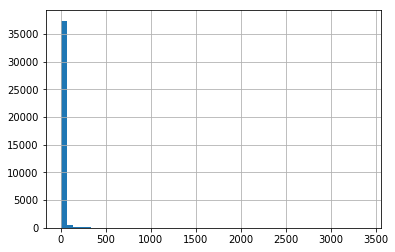

In [11]:
tags.tag.value_counts().hist(bins=50)

In [12]:
#create documents from tags
tags.fillna("", inplace=True)
tags = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "{%s}" % ' '.join(x)))
tags.reset_index(inplace=True)
movie_id = tags.movieId
print("There are {} unique movies".format(len(movie_id)))
tags.sample(10)

There are 26744 unique movies


,movieId,tag
20901,20901,{BD-R}
23852,23852,{}
7317,7317,{NOT JONNY DEPP adapted from:play cannibalism ...
25574,25574,{Clarence Brown}
6677,6677,{funny Kate Moss Miranda Richardson Rowan Atki...
24260,24260,{}
2081,2081,{incest Chris Cooper crime mystery texas great...
5722,5722,{religion true story 1970s Catholicism Christi...
15008,15008,{}
1916,1916,{dialogue driven psychological twist ending le...


In [13]:
# add genres to document
tags = pd.merge(movies, tags, left_index=True, right_on='movieId', how='right')
tags['document'] = tags[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)
tags.head(3)

,title,genres,userId,rating,timestamp,movieId,tag,document
0,Jumanji (1995),Adventure Children Fantasy,1,3.5,1112486027,0,{time travel adapted from:book board game chil...,{time travel adapted from:book board game chil...
1,"City of Lost Children, The (Cité des enfants p...",Adventure Drama Fantasy Mystery SciFi,1,3.5,1112484676,1,{children Santa Claus dystopia abused children...,{children Santa Claus dystopia abused children...
2,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery SciFi Thriller,1,3.5,1112484819,2,{post-apocalyptic psychology time travel Brad ...,{post-apocalyptic psychology time travel Brad ...


In [17]:
tags[tags['title'].str.contains("Lord of the Rings")]

,title,genres,userId,rating,timestamp,movieId,tag,document
131,"Lord of the Rings: The Fellowship of the Ring,...",Adventure Fantasy,1,5.0,1112484682,131,{adventure characters epic fantasy world fight...,{adventure characters epic fantasy world fight...
142,"Lord of the Rings: The Two Towers, The (2002)",Adventure Fantasy,1,5.0,1112484619,142,{Action fantasy multiple storylines Watched ad...,{Action fantasy multiple storylines Watched ad...
158,"Lord of the Rings: The Return of the King, The...",Action Adventure Drama Fantasy,1,5.0,1112484633,158,{Watched adapted from:book author:J. R. R. Tol...,{Watched adapted from:book author:J. R. R. Tol...
2424,"Lord of the Rings, The (1978)",Adventure Animation Children Fantasy,58,5.0,1144061097,2424,{adapted from:book author:J. R. R. Tolkein hig...,{adapted from:book author:J. R. R. Tolkein hig...


In [18]:
tags.query('movieId == 131').document.values

array(["{adventure characters epic fantasy world fighting photography Action adventure atmospheric based on a book based on book beautifully filmed ensemble cast fantasy fantasy world high fantasy imdb top 250 magic music nature nothing at all Oscar (Best Cinematography) Oscar (Best Effects - Visual Effects) scenic stylized Tolkien wizards adventure atmospheric ensemble cast fantasy fantasy world magic stylized wizards Watched adapted from:book author:J. R. R. Tolkein based on book epic fantasy middle earth faithful to book fantasy good versus evil high fantasy joseph campbell's study of mythology influenced magic atmospheric boring high fantasy Action adventure atmospheric based on a book beautifully filmed fantasy high fantasy magic music mythology romance stylized time travel Viggo Mortensen wizards Peter Jackson Peter Jackson music must see Tolkien high fantasy Myth Tolkien wizards Ian McKellen bast background universe complex script joseph campbell's study of mythology influenced 

In [14]:
tags.query('title == "Zodiac (2007)"').document.values

array(["{serial killer based on a true story serial killer; based on a true story long obsession serial killer based on a true story serial killer crime David Fincher investigation investigative journalism Jake Gyllenhaal long Mark Ruffalo Robert Downey Jr. serial killer slow Too long based on a true story detective investigation Journalist obsession David Fincher Jake Gyllenhaal Mark Ruffalo Robert Downey Jr bad ending Jake Gyllenhaal length Robert Downey Jr adapted from:true story based on a true story ChloÃ« Sevigny David Fincher detective great character development investigative journalism Jake Gyllenhaal John Carroll Lynch long Mark Ruffalo mind games obsession Robert Downey Jr. serial killer police based on a true story detective investigation police serial killer based on a true story Robert Downey Jr serial killer Too long true story cinematography David Fincher stylized investigative journalism obsession police police based on a true story based on a true story crime obsessio

In [14]:
tags.query('title == "Zodiac (2007)"').document.values

array(["{serial killer based on a true story serial killer; based on a true story long obsession serial killer based on a true story serial killer crime David Fincher investigation investigative journalism Jake Gyllenhaal long Mark Ruffalo Robert Downey Jr. serial killer slow Too long based on a true story detective investigation Journalist obsession David Fincher Jake Gyllenhaal Mark Ruffalo Robert Downey Jr bad ending Jake Gyllenhaal length Robert Downey Jr adapted from:true story based on a true story ChloÃ« Sevigny David Fincher detective great character development investigative journalism Jake Gyllenhaal John Carroll Lynch long Mark Ruffalo mind games obsession Robert Downey Jr. serial killer police based on a true story detective investigation police serial killer based on a true story Robert Downey Jr serial killer Too long true story cinematography David Fincher stylized investigative journalism obsession police police based on a true story based on a true story crime obsessio

In [11]:
tags.query('movieId == 19849')

,title,genres,userId,rating,timestamp,movieId,tag,document
19849,"Waiting Game, The (2000)",Comedy,29879,2.5,1161368462,19849,{},{} Comedy


# TFIDF

In [ ]:
#TO DO run and save tfisd matrix for autencoder with muc more features. 

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    ngram_range=(0, 1),
    min_df=0.0001,
    stop_words='english')
tfidf_matrix = tfidf.fit_transform(tags['document'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=tags.index.tolist())
print(tfidf_df.shape)
tfidf_df.head(3)

(26744, 9697)


,0,1,2,3,4,5,6,7,8,9,...,9687,9688,9689,9690,9691,9692,9693,9694,9695,9696
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
tfidf.vocabulary_

{'time': 8713,
 'travel': 8855,
 'adapted': 202,
 'book': 1059,
 'board': 1020,
 'game': 3383,
 'childhood': 1553,
 'recaptured': 7141,
 'herds': 3960,
 'cgi': 1462,
 'animals': 452,
 'scary': 7624,
 'fantasy': 3003,
 'robin': 7355,
 'williams': 9452,
 'joe': 4606,
 'johnston': 4617,
 'kid': 4799,
 'flick': 3188,
 'jungle': 4680,
 'adventure': 226,
 'children': 1555,
 'dynamic': 2613,
 'action': 186,
 'kirsten': 4838,
 'dunst': 2588,
 'childish': 1554,
 'filmed': 3125,
 'bc': 815,
 'bad': 706,
 'based': 788,
 'chris': 1589,
 'van': 9128,
 'allsburg': 342,
 'magic': 5374,
 'monkey': 5883,
 'saturn': 7593,
 'award': 675,
 'best': 904,
 'special': 8145,
 'effects': 2679,
 'supporting': 8428,
 'actress': 191,
 'clv': 1712,
 'horrifying': 4116,
 'horror': 4117,
 'genre': 3470,
 'kids': 4804,
 'santa': 7567,
 'claus': 1652,
 'dystopia': 2620,
 'abused': 168,
 'surreal': 8437,
 'bleak': 984,
 'dark': 2134,
 'visually': 9238,
 'appealing': 510,
 'atmospheric': 615,
 'dreamlike': 2523,
 'fancif

In [47]:
tfidf_df.to_pickle('../data/tfidf_matrix.pkl')